In [7]:
# CELDA 1 — imports y carga del CSV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib
import os

# Poner aquí la ruta exacta donde guardaste el CSV
csv_path = "data/AIMLDataset.csv"  # o "ruta/completa/AIMLDataset.csv"
assert os.path.exists(csv_path), f"Archivo no encontrado: {csv_path}"

df = pd.read_csv(csv_path)
print("Dataset cargado. Shape:", df.shape)
df.head()


Dataset cargado. Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# CELDA 2 — Información general
print("=== Info del Dataset ===")
print(df.info())

print("\n=== Primeras 5 filas ===")
print(df.head())

print("\n=== Columnas ===")
print(df.columns.tolist())


=== Info del Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None

=== Primeras 5 filas ===
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYME

In [7]:
# CELDA 3 — Nulos y duplicados
print("=== Valores nulos por columna ===")
print(df.isnull().sum())

print("\n=== Duplicados ===")
print(df.duplicated().sum())


=== Valores nulos por columna ===
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

=== Duplicados ===
0


In [8]:
# CELDA 4 — Conteo de clases y tipos
print("=== Conteo de Fraudes ===")
print(df['isFraud'].value_counts())

print("\n=== Tipos de Transacción ===")
print(df['type'].value_counts())


=== Conteo de Fraudes ===
isFraud
0    6354407
1       8213
Name: count, dtype: int64

=== Tipos de Transacción ===
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


In [9]:
# CELDA 5 — Estadísticas de Amount
print("=== Estadísticas de Amount ===")
print(df['amount'].describe(percentiles=[.01,.05,.1,.25,.5,.75,.95,.99]))


=== Estadísticas de Amount ===
count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
1%       4.494676e+02
5%       2.224100e+03
10%      4.501300e+03
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
95%      5.186342e+05
99%      1.615979e+06
max      9.244552e+07
Name: amount, dtype: float64


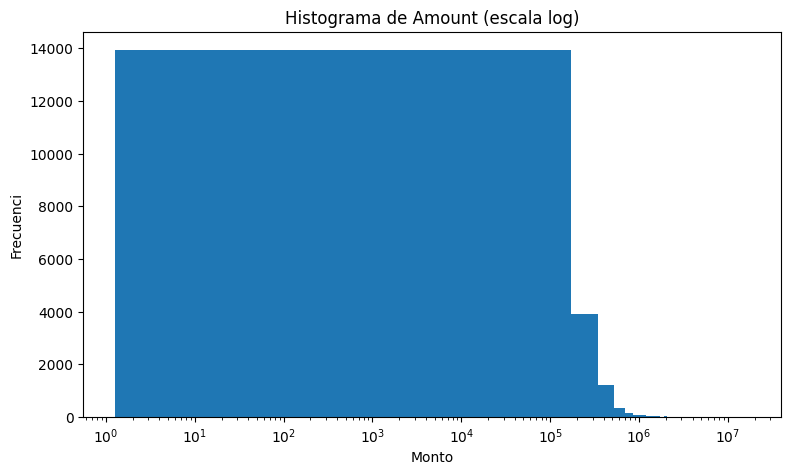

In [13]:
# CELDA 6 — Histograma de Amount
plt.figure(figsize=(9,5))
plt.hist(df['amount'].sample(n=20000, random_state=42), bins=100)
plt.xscale('log')  # Escala log para ver mejor
plt.title("Histograma de Amount (escala log)")
plt.xlabel("Monto")
plt.ylabel("Frecuenci")
plt.show()


In [11]:
# CELDA 7 — Validación de balances
df['check_balance'] = (df['oldbalanceOrg'] - df['amount']) - df['newbalanceOrig']
print(df['check_balance'].describe())


count    6.362620e+06
mean    -2.010925e+05
std      6.066505e+05
min     -9.244552e+07
25%     -2.496411e+05
50%     -6.867726e+04
75%     -2.954230e+03
max      1.000000e-02
Name: check_balance, dtype: float64


<Figure size 1000x600 with 0 Axes>

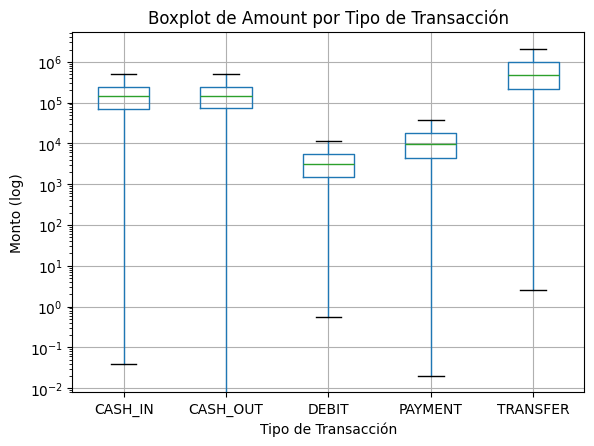

In [14]:
plt.figure(figsize=(10,6))
df.boxplot(column="amount", by="type", showfliers=False)  # showfliers=False oculta outliers extremos
plt.yscale("log")  # Usamos escala logarítmica para ver mejor
plt.title("Boxplot de Amount por Tipo de Transacción")
plt.suptitle("")  # Quita el título automático de pandas
plt.xlabel("Tipo de Transacción")
plt.ylabel("Monto (log)")
plt.show()

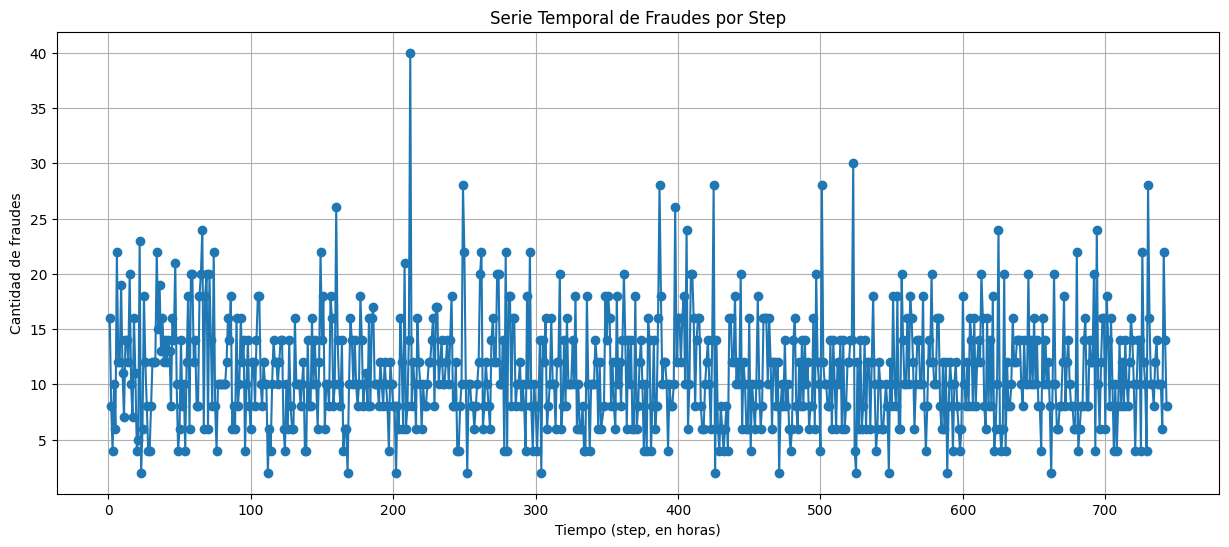

In [16]:
fraudes_por_step = df[df["isFraud"] == 1].groupby("step").size()

plt.figure(figsize=(15,6))
plt.plot(fraudes_por_step.index, fraudes_por_step.values, marker="o", linestyle="-")
plt.title("Serie Temporal de Fraudes por Step")
plt.xlabel("Tiempo (step, en horas)")
plt.ylabel("Cantidad de fraudes")
plt.grid(True)
plt.show()